In [ ]:
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torchvision.transforms.v2 as v2
import torchvision.datasets
from torch.utils.data import DataLoader, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt

import random

from tqdm import tqdm

In [ ]:
transform = v2.Compose([
    v2.Resize([64,64]),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

train_data = torchvision.datasets.Flowers102("dataset/flowers102", split="train", transform=transform, download=True)
val_data = torchvision.datasets.Flowers102("dataset/flowers102", split="val", transform=transform, download=True)
test_data = torchvision.datasets.Flowers102("dataset/flowers102", split="test", transform=transform, download=True)

# train_data = ConcatDataset([train_data, val_data, test_data])

100%|██████████| 344862509/344862509 [00:16<00:00, 21040274.02it/s]


Extracting dataset/flowers102/flowers-102/102flowers.tgz to dataset/flowers102/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1330095.14it/s]


100%|██████████| 14989/14989 [00:00<00:00, 28344645.02it/s]


In [ ]:
print(len(train_data))

1020


torch.Size([3, 64, 64])
tensor([0.0667, 0.0588, 0.0667, 0.0627, 0.1412])


<Figure size 1000x200 with 0 Axes>

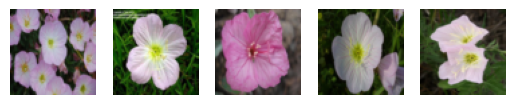

In [ ]:
print(train_data[0][0].shape)
print(train_data[0][0][0,0,:5])

plt.figure(figsize=(10,2))
fig, axs = plt.subplots(nrows=1, ncols=5)
for i in range(5):
    axs[i].axis('off')
    axs[i].imshow(train_data[i][0].permute(1,2,0))

plt.show()


tensor([0.0001, 0.0002, 0.0004, 0.0005, 0.0007])
tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993])


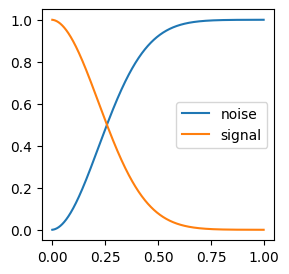

In [ ]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + torch.tensor(diffusion_times) * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, dim = 0)
    signal_rates = alpha_bars
    noise_rates = 1 - alpha_bars
    return noise_rates, signal_rates

T = 1000
diffusion_times = [x/T for x in range(T)]
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(diffusion_times)
print(linear_noise_rates[:5])
print(linear_signal_rates[:5])
plt.figure(figsize=(3,3))
plt.plot(diffusion_times, linear_noise_rates, label="noise")
plt.plot(diffusion_times, linear_signal_rates, label="signal")
plt.legend()
plt.show()

In [ ]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = torch.cos(diffusion_times * torch.pi / 2)
    noise_rates = torch.sin(diffusion_times * torch.pi / 2)
    return noise_rates, signal_rates

def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = torch.tensor(0.02)
    max_signal_rate = torch.tensor(0.95)
    start_angle = torch.acos(max_signal_rate)
    end_angle = torch.acos(min_signal_rate)
    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
    signal_rates = torch.cos(diffusion_angles)
    noise_rates = torch.sin(diffusion_angles)

    return noise_rates, signal_rates

T = 1000
diffusion_times = [x/T for x in range(T)]
diffusion_times = torch.tensor(diffusion_times, dtype=torch.float32)

cos_noise_rates, cos_signal_rates = cosine_diffusion_schedule(diffusion_times)
off_cos_noise_rates, off_cos_signal_rates = offset_cosine_diffusion_schedule(diffusion_times)

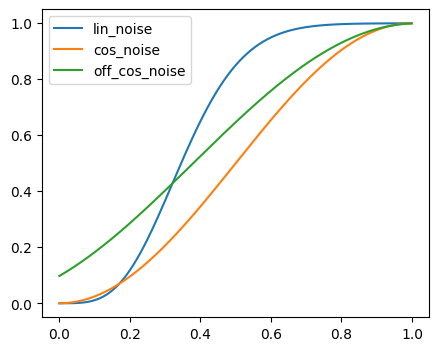

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(diffusion_times, linear_noise_rates**2, label="lin_noise")
plt.plot(diffusion_times, cos_noise_rates**2, label="cos_noise")
plt.plot(diffusion_times, off_cos_noise_rates**2, label="off_cos_noise")
plt.legend()
plt.show()

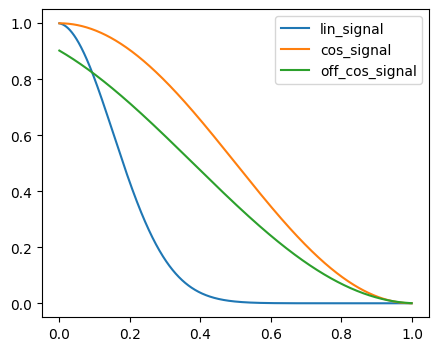

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(diffusion_times, linear_signal_rates**2, label="lin_signal")
plt.plot(diffusion_times, cos_signal_rates**2, label="cos_signal")
plt.plot(diffusion_times, off_cos_signal_rates**2, label="off_cos_signal")
plt.legend()
plt.show()

In [ ]:
import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        emb = emb.reshape(emb.shape[0], -1, 1, 1)
        return emb

model = SinusoidalPosEmb(dim=32)
sample = torch.tensor(0.34, dtype=torch.float32)
sample = sample.reshape([1,1,1])
sample = sample.repeat(3,1,1,1)
print(sample)
print(sample.shape)
res = model(sample)
print(res[0,:3,])
print(res[1,:3,])
print("SinusoidalPosEmb", res.shape)

tensor([[[[0.3400]]],


        [[[0.3400]]],


        [[[0.3400]]]])
torch.Size([3, 1, 1, 1])
tensor([[[0.3335]],

        [[0.1830]],

        [[0.0994]]])
tensor([[[0.3335]],

        [[0.1830]],

        [[0.0994]]])
SinusoidalPosEmb torch.Size([3, 32, 1, 1])


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.in_channel = in_channel
        self.out_channel = out_channels
        self.conv_input = nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.swish = nn.SiLU()

    def forward(self, x):
        input_width = x.shape[1]
        if input_width == self.out_channel:
            residual = x
        else:
            residual = self.conv_input(x)

        x = self.conv1(x)
        x = self.swish(x)
        x = self.conv2(x)
        x = torch.add(x, residual)

        return x

model = ResidualBlock(3, 64)
sample = torch.randn([1,3,64,64])
res = model(sample)
print("ResidualBlock", res.shape)

ResidualBlock torch.Size([1, 64, 64, 64])


In [ ]:

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.res1 = ResidualBlock(in_channel=self.in_channels, out_channels=self.out_channels)
        self.res2 = ResidualBlock(in_channel=self.out_channels, out_channels=self.out_channels)

        self.avg_pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x):
        res_out_1 = self.res1(x)
        res_out_2 = self.res2(res_out_1)
        out = self.avg_pool(res_out_2)

        return out, res_out_1, res_out_2

model = DownBlock(in_channels=64, out_channels=32)
sample = torch.randn([1,64,64,64])
out, skip1, skip2 = model(sample)
print(out.shape)
print(skip1.shape)
print(skip2.shape)

torch.Size([1, 32, 32, 32])
torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 64, 64])


In [ ]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, skip_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.skip_channels = skip_channels

        self.up_sample = nn.UpsamplingBilinear2d(scale_factor=2)
        self.res1 = ResidualBlock(in_channel=self.in_channels + skip_channels, out_channels=out_channels)
        self.res2 = ResidualBlock(in_channel=self.out_channels + skip_channels, out_channels=out_channels)

    def forward(self, x, skip1, skip2):
        out = self.up_sample(x)
        out = torch.cat([out, skip2], dim=1)
        out = self.res1(out)
        out = torch.cat([out, skip1], dim=1)
        out = self.res2(out)
        return out

model = UpBlock(in_channels=128, out_channels=96, skip_channels=96)
skip1 = torch.randn([1,96,16,16])
skip2 = torch.randn([1,96,16,16])
sample = torch.randn([1,128,8,8])

out = model(sample, skip1, skip2)
print("UpBlock", out.shape)


UpBlock torch.Size([1, 96, 16, 16])


In [ ]:
class UNet(nn.Module):
    def __init__(self, emb_dim, input_size, in_channel, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.emb_dim = emb_dim
        self.input_size = input_size
        self.in_channel = in_channel

        self.sinusodialPosEmb = SinusoidalPosEmb(self.emb_dim)
        self.upsample = nn.UpsamplingNearest2d(size=self.input_size)

        self.conv_in = nn.Conv2d(in_channels=in_channel, out_channels=emb_dim, kernel_size=3, padding=1)

        self.down_block1 = DownBlock(in_channels=emb_dim*2, out_channels=emb_dim)
        self.down_block2 = DownBlock(in_channels=emb_dim, out_channels=emb_dim*2)
        self.down_block3 = DownBlock(in_channels=emb_dim*2, out_channels=emb_dim*3)

        self.res_1 = ResidualBlock(in_channel=emb_dim*3, out_channels=emb_dim*4)
        self.res_2 = ResidualBlock(in_channel=emb_dim*4, out_channels=emb_dim*4)

        self.up_block1 = UpBlock(in_channels=emb_dim*4, out_channels=emb_dim*3, skip_channels=emb_dim*3)
        self.up_block2 = UpBlock(in_channels=emb_dim*3, out_channels=emb_dim*2, skip_channels=emb_dim*2)
        self.up_block3 = UpBlock(in_channels=emb_dim*2, out_channels=emb_dim, skip_channels=emb_dim)

        self.conv_out = nn.Conv2d(in_channels=emb_dim, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x_t, time_step):
        noise_emb = self.sinusodialPosEmb(time_step)
        noise_emb = self.upsample(noise_emb)
        xt_emb = self.conv_in(x_t)
        emb = torch.cat([noise_emb, xt_emb], dim=1)
        out, db1_skip1, db1_skip2 = self.down_block1(emb)
        out, db2_skip1, db2_skip2 = self.down_block2(out)
        out, db3_skip1, db3_skip2 = self.down_block3(out)

        out = self.res_1(out)
        out = self.res_2(out)

        out = self.up_block1(out, db3_skip1, db3_skip2)
        out = self.up_block2(out, db2_skip1, db2_skip2)
        out = self.up_block3(out, db1_skip1, db1_skip2)

        out = self.conv_out(out)
        return out

model = UNet(emb_dim=32, input_size=64, in_channel=3)
xt_sample = torch.randn([5,3,64,64])
noise_sample = torch.tensor(0.34, dtype=torch.float32)
noise_sample = noise_sample.reshape([1,1,1])
noise_sample = noise_sample.repeat(5,1,1,1)
out = model(xt_sample, noise_sample)
print(out.shape)

torch.Size([5, 3, 64, 64])


epoch[0]:   0%|          | 0/8 [00:00<?, ?it/s, loss:0.80235755443573]


epoch[0], loss mean : 0.80235755443573
torch.Size([1, 3, 64, 64])


IndexError: only integers, slices (`:`), ellipsis (`...`), None and long or byte Variables are valid indices (got float)

<Figure size 1000x200 with 0 Axes>

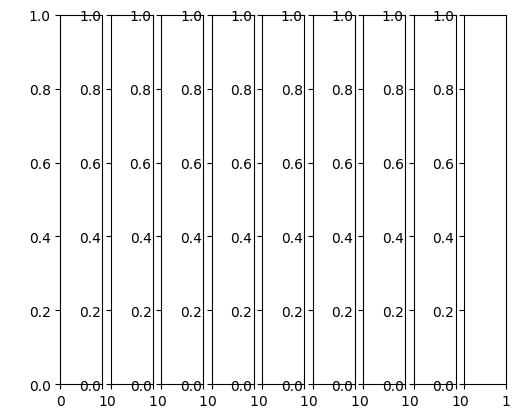

In [ ]:
class DiffusionTrainer():
    def __init__(self, model, loss, optim) -> None:
        self.model = model
        self.normalizer = v2.Normalize(
            mean=[0.485, 0.456, 0.406]
            ,std=[0.229, 0.224, 0.225]
            )
        self.diffusion_schedule = offset_cosine_diffusion_schedule
        self.criterion = loss
        self.optim = optim

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        pred_noises = model(noisy_images, noise_rates)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images


    def train_step(self, images):
        self.optim.zero_grad()
        images = self.normalizer(images)
        noises = torch.randn_like(images)
        noises = noises.to(images.device)
        batch_size = images.shape[0]
        diffusion_times = torch.rand(size=[batch_size, 1, 1, 1])
        diffusion_times = diffusion_times.to(images.device)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # x_t = \sqrt{\bar{\alpha}_t} + \sqrt{1 - \bar{\alpha}_t} noise
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates, True)
        loss = self.criterion(noises, pred_noises)
        loss.backward()
        self.optim.step()

        return loss.item()

    def test_step(self, image):
        image = self.normalizer(image)
        noises = torch.randn_like(image)
        noises = noises.to(image.device)

        batch_size = image.shape[0]
        diffusion_times = torch.rand(size=[batch_size, 1, 1, 1])
        diffusion_times = diffusion_times.to(image.device)
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # x_t = \sqrt{\bar{\alpha}_t} + \sqrt{1 - \bar{\alpha}_t} noise
        noisy_images = signal_rates * image + noise_rates * noises

        noised_img = self.denormalize(noisy_images).detach().cpu()

        print(noised_img.shape)

        plt.figure(figsize=(10,2))
        fig, axs = plt.subplots(nrows=1, ncols=10)
        step_size = noise_rates.shape[0] / 10
        for i in range(10):
            axs[i].axis('off')
            axs[i].imshow(noised_img[i*step_size].permute(1,2,0))

        plt.show()


        # pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates, True)
        # loss = self.criterion(noises, pred_noises)
        # return loss.item()

    def denormalize(self, images):
        mean = torch.tensor(self.normalizer.mean).view(-1, 1, 1)
        std = torch.tensor(self.normalizer.std).view(-1, 1, 1)
        mean = mean.to(images.device)
        std = std.to(images.device)
        images = mean + images * std
        return torch.clip(images, 0.0, 1.0)

    def reverse_diffusion(self, initial_noise, diffusion_steps, device):
        initial_noise = initial_noise.to(device)
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = torch.ones([num_images, 1, 1, 1])
            diffusion_times = diffusion_times - step * step_size
            diffusion_times = diffusion_times.to(device)
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates, False
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
        return pred_images

    def generate(self, num_images, diffusion_steps, device, image_size=64, initial_noise=None):
        if initial_noise is None:
            initial_noise = torch.randn([num_images, 3, image_size,image_size])
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps, device
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def log_images(self, device):
        self.model.eval()
        generated_images = self.generate(num_images=5, diffusion_steps=20, device=device)

        plt.figure(figsize=(10,2))
        fig, axs = plt.subplots(nrows=1, ncols=5)
        for i in range(5):
            axs[i].axis('off')
            axs[i].imshow(generated_images[i].detach().cpu().permute(1,2,0))

        plt.show()



    def train(self, n_epoch, train_dl, device):
        self.model = self.model.to(device)

        for epoch in range(n_epoch):
            self.model.train()
            pbar = tqdm(train_dl)
            pbar.set_description(f"epoch[{epoch}]")
            loss_sum = 0
            total_cnt = 0

            for _, (images, _) in enumerate(pbar):
                images = images.to(device)
                loss = self.train_step(images)
                loss_sum += loss * images.shape[0]
                total_cnt += images.shape[0]
                pbar.set_postfix_str(f"loss:{loss}")
                break

            avg_loss = loss_sum/total_cnt
            print(f"epoch[{epoch}], loss mean : {avg_loss}")

            if epoch%5 == 0:
                images, _ = next(iter(pbar))
                images = images[:1]
                images = images.to(device)
                self.test_step(images)

                self.log_images(device)

model = UNet(emb_dim=32, input_size=64, in_channel=3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.L1Loss()

trainer = DiffusionTrainer(model, criterion, optimizer)
dl = DataLoader(train_data, batch_size=128)
device = "cuda" if torch.cuda.is_available() else "cpu"
trainer.train(1, dl, device)